# Applied ML War Building Damage - Data Exploration

Matteo Larrode, MSc Social Data Science 

Oxford Internet Institute, University of Oxford

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from pathlib import Path

# Add the project root to the Python path to import the modules
project_root = Path().absolute().parent
sys.path.append(str(project_root))

from src.data.preprocess import load_building_data
from src.visualisation.maps import parse_geo_column, create_folium_map

In [3]:
# ---- Focus on Gaza data ----
region_name = "Gaza"
gaza_data = load_building_data(region_name)

Loaded footprint data from: Gaza_20240503_1_footprints.csv
Loaded grid data from: Gaza_20240503_2_grid.csv


/Users/matteolarrode/Documents/Oxford/Applied ML/Summative/ML-BuildingDamageViaSatellite/src/data/preprocess.py:40: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  result['footprints'] = pd.read_csv(footprint_path)


## Data Loading and Basic Analysis (Gaza)


--- Gaza Footprints Data Summary ---
Shape: (228730, 13)

Columns:
 - system:index
 - area
 - building
 - class
 - damage_pts
 - k100
 - k150
 - k50
 - max_change
 - name
 - osm_id
 - osm_type
 - .geo

Data types:
system:index     object
area            float64
building         object
class             int64
damage_pts        int64
k100            float64
k150            float64
k50             float64
max_change      float64
name             object
osm_id            int64
osm_type         object
.geo             object
dtype: object

First 5 rows:
           system:index         area building  class  damage_pts      k100  \
0  00000000000000032e7e   237.967586   church      1           1  3.196825   
1  00000000000000032e33  2960.776123   mosque      1           4  4.270218   
2  00000000000000032e6f   937.639565   mosque      1           1  4.604129   
3  00000000000000032e38   772.664673   public      1           7  3.856997   
4  00000000000000032e90  1950.263063   public      1  

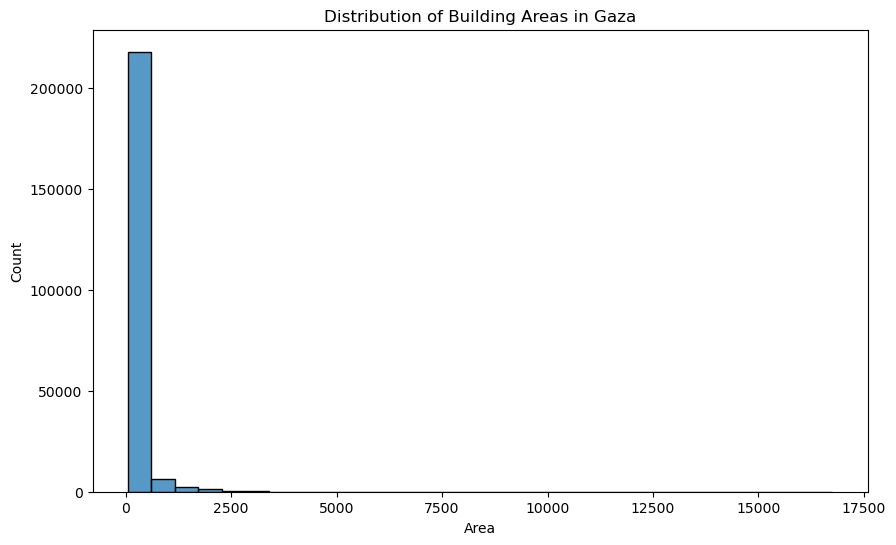

In [27]:
# ---- Footprints data ----
# Load the data
gaza_footprints = gaza_data['footprints']

if gaza_footprints is not None:
    print("\n--- Gaza Footprints Data Summary ---")
    print(f"Shape: {gaza_footprints.shape}")
    print("\nColumns:")
    for col in gaza_footprints.columns:
        print(f" - {col}")
    
    print("\nData types:")
    print(gaza_footprints.dtypes)
    
    print("\nFirst 5 rows:")
    print(gaza_footprints.head())
    
    print(f"\nPercent of buildings damaged: {sum(gaza_footprints['class'] / len(gaza_footprints)) * 100:.2f}%")

    # Visualize building areas
    plt.figure(figsize=(10, 6))
    sns.histplot(gaza_footprints['area'], bins=30)
    plt.title('Distribution of Building Areas in Gaza')
    plt.xlabel('Area')
    plt.ylabel('Count')
    plt.show()

In [28]:
# ---- Grid data ----
gaza_grid = gaza_data['grid']

if gaza_grid is not None:
    print("\n--- Gaza Grid Data Summary ---")
    print(f"Shape: {gaza_grid.shape}")
    print("\nColumns:")
    for col in gaza_grid.columns:
        print(f" - {col}")
    
    print("\nData types:")
    print(gaza_grid.dtypes)
    
    print("\nFirst 5 rows:")
    print(gaza_grid.head())
    
    # Basic statistics
    print("\nSummary statistics:")
    print(gaza_grid.describe())
    
    print(f"\nPercent of grid points damaged: {sum(gaza_grid['class'] / len(gaza_grid)) * 100:.2f}%")



--- Gaza Grid Data Summary ---
Shape: (1784, 9)

Columns:
 - system:index
 - class
 - damage_pts
 - k100
 - k150
 - k50
 - max_change
 - urban
 - .geo

Data types:
system:index     object
class             int64
damage_pts        int64
k100            float64
k150            float64
k50             float64
max_change      float64
urban           float64
.geo             object
dtype: object

First 5 rows:
  system:index  class  damage_pts      k100      k150       k50  max_change  \
0    7628,7326      1           3  2.873321  2.756077  2.965370    3.009428   
1    7628,7327      1           7  2.832489  2.824138  2.847125    2.843848   
2    7627,7328      1           7  2.708110  2.640692  2.769818    2.809486   
3    7628,7328      1          22  3.882189  3.855844  3.884454    3.886829   
4    7629,7328      1           4  3.042172  2.957090  3.131401    3.167469   

      urban                                               .geo  
0  0.184330  {"geodesic":false,"crs":{"type":"name

### Map of damaged buildings in Gaza

In [ ]:
print("Converting Gaza footprints to GeoDataFrame...")
gaza_footprints_gdf = parse_geo_column(gaza_footprints)
    
print("Creating map showing damaged vs. undamaged buildings (using 'class' column)...")
damage_class_map = create_folium_map(
    gaza_footprints_gdf,
    title="Gaza Building Damage",
    use_class_for_damage=True
)

display(damage_class_map)

## Exploration of UNOSAT data

### Explore raw data to prepare preprocessing

In [7]:
import folium
from folium.plugins import MarkerCluster, HeatMap
import datetime
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from src.data.preprocess import list_gdb_layers, load_all_unosat_damage_sites, inspect_layer_properties

In [ ]:
# Function to find all available UNOSAT GDB directories
def find_all_unosat_gdbs():
    """Find all UNOSAT GDB directories organized by date."""
    project_root = Path().absolute().parent
    labels_dir = os.path.join(project_root, "data", "raw", "labels")
    
    # Check if the directory exists
    if not os.path.exists(labels_dir):
        print(f"UNOSAT data directory not found: {labels_dir}")
        return {}
    
    # Find all date subdirectories
    date_dirs = {}
    for date_dir in os.listdir(labels_dir):
        full_path = os.path.join(labels_dir, date_dir)
        if os.path.isdir(full_path):
            # Find GDB files in this directory
            for root, dirs, files in os.walk(full_path):
                for dir_name in dirs:
                    if dir_name.endswith('.gdb'):
                        gdb_path = os.path.join(root, dir_name)
                        date_dirs[date_dir] = gdb_path
                        break
    
    return date_dirs

# Find all available UNOSAT GDB files
date_gdbs = find_all_unosat_gdbs()

# Get the newest
gdb_path_newest = list(date_gdbs.values())[0]

In [9]:
# Check damage in the first dataset
layers = list_gdb_layers(gdb_path_newest)
print(f"\nLayers in the GDB ({len(layers)} layers):")
for i, layer in enumerate(layers):
    print(f"{i+1}. {layer}")

# Load all layers
damage_data = load_all_unosat_damage_sites()


Layers in the GDB (5 layers):
1. Damage_Sites_GazaStrip_20250225
2. fras_aux_IDP_Sites_Template_FC
3. fras_blk_IDP_Sites_Template_FC
4. fras_bnd_IDP_Sites_Template_FC
5. fras_ras_IDP_Sites_Template_FC
Found 1 UNOSAT GDB datasets:
 - 25_02_2025: /Users/matteolarrode/Documents/Oxford/Applied ML/Summative/ML-BuildingDamageViaSatellite/data/raw/labels/unosat/25_02_2025/UNOSAT_GazaStrip_CDA_25February2025.gdb
Loaded layer 'Damage_Sites_GazaStrip_20250225' with 173350 features
Loaded 173350 damage points from 25_02_2025 (Damage_Sites_GazaStrip_20250225)


In [10]:
# Inspect the damage layer
gdf = inspect_layer_properties(gdb_path_newest, layers[0])

Inspecting layer: Damage_Sites_GazaStrip_20250225 in /Users/matteolarrode/Documents/Oxford/Applied ML/Summative/ML-BuildingDamageViaSatellite/data/raw/labels/unosat/25_02_2025/UNOSAT_GazaStrip_CDA_25February2025.gdb

Basic Information:
Number of features: 173350
Geometry type: Point
CRS: COMPD_CS["WGS 84 + EGM96 height",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]],VERT_CS["EGM96 height",VERT_DATUM["EGM96 geoid",2005,AUTHORITY["EPSG","5171"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Gravity-related height",UP],AUTHORITY["EPSG","5773"]]]

Columns (64 total):
 - SiteID: int16, 173350/173350 non-null values
   Sample values: [26, 26, 26]
 - SensorDate: datetime64[ms, UTC], 14270/173350 non-null values
   Sample values: [Timestamp(

### Explore preprocessed data

In [ ]:
# Load the GeoJSON file
gaza_labels_gdf = gpd.read_file('../data/raw/labels/gaza_unosat_labels.geojson')

# Convert to DataFrame
gaza_labels_df = pd.DataFrame(gdf)